In [11]:
import requests
import json
import csv
import time
from urllib.parse import urlparse
import os
import string
import matplotlib.pyplot as plt
import re
import random
import unicodedata
from underthesea import word_tokenize, text_normalize
from collections import Counter
from wordcloud import WordCloud
import pandas as pd

In [12]:
csv_output_file = './data/crawl/tiktok_comments.csv'
labeled_csv_output_file = './data/crawl/tiktok_comments_labeled.csv'
repaired_csv = './data/crawl/tiktok_comments_clean.csv'
stopword_path ='./data/vietnamese-stopwords.txt'

In [13]:
# ─── Các hàm tiện ích ──────────────────────────────────────────────────────────

# def clean_and_tokenize_text(text):
#     text = re.sub(r'@\S+', '', text)
#     text = re.sub(r'\s+', ' ', text).strip()
#     if not text:
#         return ""
#     text = unicodedata.normalize('NFKC', text)
#     text = text_normalize(text)
#     text = word_tokenize(text, format="text")
#     return text

# Mẫu biểu thức chính quy để loại bỏ emoji
emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"
    u"\U0001F300-\U0001F5FF"
    u"\U0001F680-\U0001F6FF"
    u"\U0001F1E0-\U0001F1FF"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u200d"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\u3030"
    u"\ufe0f"
"]+", flags=re.UNICODE)

def clean_and_tokenize_text(text):
    # Loại bỏ mention như @username
    text = re.sub(r'@\S+', '', text)

    # Loại bỏ emoji
    text = re.sub(emoji_pattern, ' ', text)

    # Viết thường
    text = text.lower()

    # Giảm ký tự lặp (vd: aaa -> a)
    text = re.sub(r'([a-zA-Zàáảãạăắằẳẵặâấầẩẫậđèéẻẽẹêếềểễệìíỉĩịòóỏõọôốồổỗộơớờởỡợùúủũụưứừửữựỳýỷỹỵ]+?)\1+', r'\1', text)

    # Thêm khoảng trắng trước/sau dấu câu nếu cần
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)

    # Giảm dấu câu lặp (vd: "!!??" -> "!")
    text = re.sub(r"([" + string.punctuation + "])([" + string.punctuation + "])+", r"\1", text)

    # Chuẩn hóa unicode
    text = unicodedata.normalize('NFKC', text)

    # Loại bỏ dấu câu cuối/cạnh mép
    text = text.strip()
    while text and text[-1] in string.punctuation + string.whitespace:
        text = text[:-1]
    while text and text[0] in string.punctuation + string.whitespace:
        text = text[1:]

    # Xóa toàn bộ dấu câu còn lại
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Xóa khoảng trắng dư thừa
    text = re.sub(r'\s+', ' ', text).strip()

    # Nếu chuỗi rỗng thì trả về ""
    if not text:
        return ""

    # Chuẩn hóa tiếng Việt nếu cần
    text = text_normalize(text)

    # Tokenize tiếng Việt, dạng text
    text = word_tokenize(text, format="text")

    return text

def is_mostly_non_vietnamese(text, threshold=0.8):
    text_letters = ''.join(c for c in text if c.isalpha())
    if len(text_letters) == 0:
        return True
    non_latin_chars = sum(1 for c in text_letters if not ('\u0000' <= c <= '\u024F'))
    return (non_latin_chars / len(text_letters)) >= threshold

def load_stopwords(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return set(line.strip().lower() for line in f if line.strip())


In [14]:
# ─── Hàm chính ──────────────────────────────────────────────────────────────────

def repair_csv_lines(input_path, output_path, stopword_path='data/vietnamese-stopwords.txt', expected_fields=3):
    buffer = ""
    first_line = True
    processed_lines = []
    all_tokens = []

    def is_valid_line(line):
        try:
            parts = list(csv.reader([line]))[0]
            if len(parts) != expected_fields:
                return False
            int(parts[0])
            int(parts[2])
            return True
        except:
            return False

    with open(input_path, 'r', encoding='utf-8') as infile, \
         open(output_path, 'w', encoding='utf-8') as outfile:

        for raw_line in infile:
            if first_line:
                outfile.write(raw_line)
                first_line = False
                continue

            line = raw_line.rstrip('\n')

            buffer = buffer + ' ' + line if buffer else line

            if is_valid_line(buffer):
                parts = list(csv.reader([buffer]))[0]
                line_number = parts[0].strip()
                raw_text = parts[1].replace('\n', ' ').strip()
                emotion_label = parts[2].strip()

                cleaned_text = clean_and_tokenize_text(raw_text)
                if not cleaned_text or is_mostly_non_vietnamese(cleaned_text):
                    buffer = ""
                    continue

                cleaned_text = cleaned_text.replace(',', ';')
                repaired_line = f'{line_number},{cleaned_text},{emotion_label}'
                outfile.write(repaired_line + '\n')
                processed_lines.append(repaired_line)

                all_tokens.extend(cleaned_text.split())

                buffer = ""

    print(f"\n✅ Đã xử lý và lưu kết quả vào: {output_path}")

    # In ngẫu nhiên 10 dòng kết quả
    print("\n📋 10 dòng ngẫu nhiên đã xử lý:")
    for line in random.sample(processed_lines, min(10, len(processed_lines))):
        print(line)

    # Tải stopwords
    stopwords = load_stopwords(stopword_path)

    # Lọc bỏ stopwords và các token không phải từ
    filtered_tokens = [t for t in all_tokens if t.isalpha() and t.lower() not in stopwords]

    # Thống kê từ vựng
    word_freq = Counter(filtered_tokens)
    print(f"\n📊 Số lượng từ sau khi lọc stopwords & dấu câu: {len(word_freq)}")
    print("🔠 15 từ xuất hiện nhiều nhất:")
    for word, count in word_freq.most_common(15):
        print(f"{word}: {count}")

    # Vẽ WordCloud
    print("\n🌥️ Vẽ WordCloud...")
    corpus = ' '.join(filtered_tokens)
    plt.figure(figsize=(12, 8))
    wordcloud = WordCloud(
        max_words=100,
        background_color="black",
        width=2000,
        height=1000,
        font_path="arial.ttf"
    ).generate(corpus)
    plt.axis("off")
    plt.imshow(wordcloud)
    plt.show()

In [15]:
def plot_emotion_distribution(csv_path):
    label_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
    total = 0

    with open(csv_path, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                label = int(row['emotion_label'])
                if label in label_counts:
                    label_counts[label] += 1
                    total += 1
            except:
                continue

    if total == 0:
        print("⚠️ Không có dữ liệu hợp lệ để thống kê.")
        return

    # Tính phần trăm
    labels = []
    sizes = []
    label_names = {
        0: 'Vui vẻ',
        1: 'Tức giận',
        2: 'Buồn',
        3: 'Sợ hãi',
        4: 'Khác'
    }

    for label, count in label_counts.items():
        if count > 0:
            labels.append(f"{label_names[label]} ({count})")
            sizes.append(count / total * 100)

    # Vẽ biểu đồ tròn
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title("Thống kê cảm xúc trong dữ liệu")
    plt.show()


✅ Đã xử lý và lưu kết quả vào: ./data/crawl/tiktok_comments_clean.csv

📋 10 dòng ngẫu nhiên đã xử lý:
10218,nó trả bao tiền r,4
12742,oai lắm đến lúc hiểu chuyện thì 1 điều nhịn 9 điều_lành 3 cháu còn nhỏ,4
2186,chắc ra đường phải mặc áo_giáp quá song cũng phải đi học khí_công có gì vận_khí cho nó không đâm vô da_thịt quá,4
8204,g o c k e m,4
20123,khổ thân 2 ks kế bên,4
18766,đau_lòng lắm,2
26163,nghe tiếng còi_hú mãi mà chẳng thấy xe cứu hỏa đâu,2
7634,hoàng_linh,4
2097,chế_độ cũ hết thời,0
28177,zha,4

📊 Số lượng từ sau khi lọc stopwords & dấu câu: 5234
🔠 15 từ xuất hiện nhiều nhất:
sợ: 1270
ko: 1261
đi: 1181
k: 958
cháy: 937
mấy: 873
t: 722
lắm: 584
xe: 503
cứu: 444
đường: 419
đời: 401
trời: 390
hỏa: 364
đc: 362

🌥️ Vẽ WordCloud...


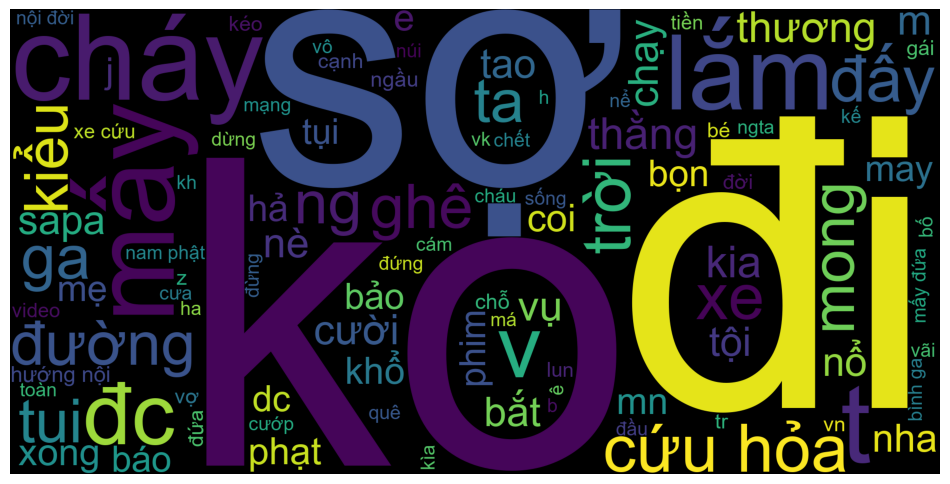

In [16]:
repair_csv_lines(labeled_csv_output_file, repaired_csv)

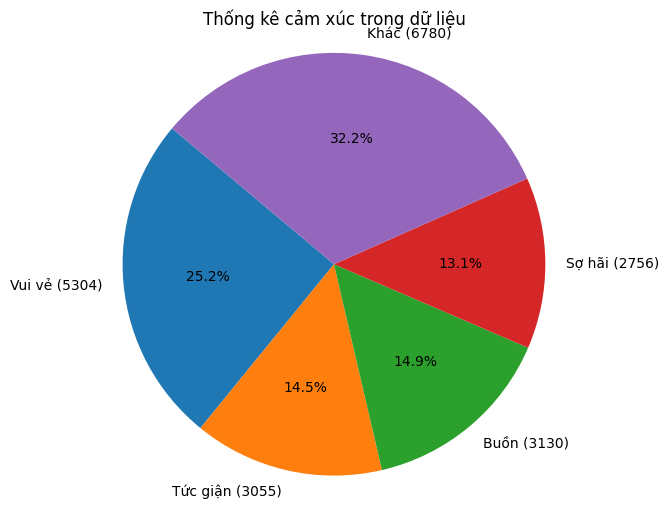

In [17]:
plot_emotion_distribution(repaired_csv)

In [18]:
def balance_emotion_data(input_csv, output_csv):
    print(f"\n⚖️ Cân bằng dữ liệu từ: {input_csv}")

    df = pd.read_csv(input_csv)
    if 'emotion_label' not in df.columns:
        print("❌ Không tìm thấy cột 'emotion_label' trong file.")
        return

    df['emotion_label'] = df['emotion_label'].astype(int)

    # Đếm số lượng theo từng nhãn
    label_counts = df['emotion_label'].value_counts()
    print("📊 Phân phối ban đầu:")
    print(label_counts)

    # Các nhãn dư cần giảm
    labels_to_reduce = [0, 1, 2, 4]

    # Tìm số lượng nhỏ nhất trong các lớp không dư
    target_count = df[~df['emotion_label'].isin(labels_to_reduce)]['emotion_label'].value_counts().min()
    print(f"\n📌 Số lượng mục tiêu mỗi lớp: {target_count}")

    balanced_dfs = []

    for label in df['emotion_label'].unique():
        subset = df[df['emotion_label'] == label]
        if label in labels_to_reduce:
            balanced_subset = subset.sample(target_count, random_state=42)
        else:
            balanced_subset = subset
        balanced_dfs.append(balanced_subset)

    balanced_df = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

    # Ghi ra file mới
    balanced_df.to_csv(output_csv, index=False, encoding='utf-8')
    print(f"\n✅ Đã lưu dữ liệu cân bằng vào: {output_csv}")
    print("📊 Phân phối sau cân bằng:")
    print(balanced_df['emotion_label'].value_counts())

In [19]:
balanced_csv = './data/crawl/tiktok_comments_balanced_v2.csv'
balance_emotion_data(repaired_csv, balanced_csv)


⚖️ Cân bằng dữ liệu từ: ./data/crawl/tiktok_comments_clean.csv
📊 Phân phối ban đầu:
emotion_label
4    6780
0    5304
2    3130
1    3055
3    2756
Name: count, dtype: int64

📌 Số lượng mục tiêu mỗi lớp: 2756

✅ Đã lưu dữ liệu cân bằng vào: ./data/crawl/tiktok_comments_balanced_v2.csv
📊 Phân phối sau cân bằng:
emotion_label
2    2756
0    2756
4    2756
1    2756
3    2756
Name: count, dtype: int64


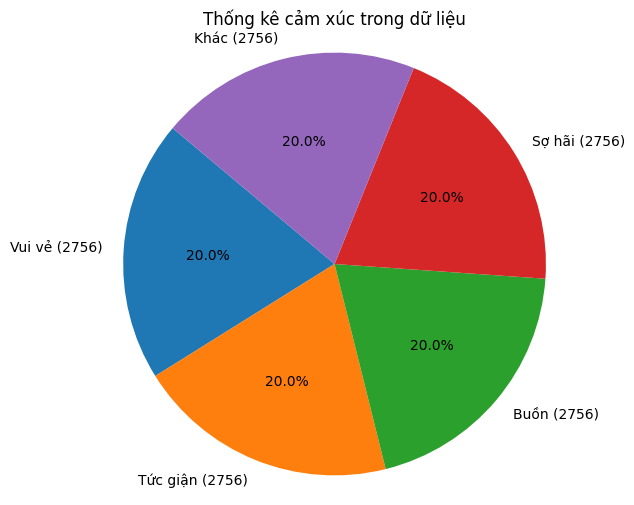

In [20]:
plot_emotion_distribution(balanced_csv)